<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import numpy as np
from pymystem3 import Mystem
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package averaged_perceptron_tagger to

[nltk_data]     /home/jovyan/nltk_data...

[nltk_data]   Package averaged_perceptron_tagger is already up-to-

[nltk_data]       date!


## Подготовка

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 159292 entries, 0 to 159291

Data columns (total 3 columns):

 #   Column      Non-Null Count   Dtype 

---  ------      --------------   ----- 

 0   Unnamed: 0  159292 non-null  int64 

 1   text        159292 non-null  object

 2   toxic       159292 non-null  int64 

dtypes: int64(2), object(1)

memory usage: 3.6+ MB


In [5]:
def clean_text(text):
    # Убираем символы новой строки
    cleaned_text = text.replace('\n', ' ')
    
    # Преобразуем в нижний регистр
    cleaned_text = cleaned_text.lower()
    
    # Удаляем символы, не являющиеся буквами или цифрами
    cleaned_text = ''.join([char for char in cleaned_text if char.isalnum() or char.isspace()])
    
    return cleaned_text

data['text'] = data['text'].apply(clean_text)
data.text[:5]

0    explanation why the edits made under my userna...
1    daww he matches this background colour im seem...
2    hey man im really not trying to edit war its j...
3     more i cant make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: text, dtype: object

In [6]:
tqdm.pandas()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Функция для лемматизации текста
def lemmatize(text, language='en'):
    if language == 'en':
        tokens = word_tokenize(text)
        pos_tags = pos_tag(tokens)
        lemmatizer = WordNetLemmatizer()
        lemmatized_text = ' '.join([lemmatizer.lemmatize(token, get_wordnet_pos(pos_tag))
                                    for token, pos_tag in pos_tags])
    else:
        m = Mystem()
        lemmatized_text = m.lemmatize(text)
    return lemmatized_text

# Применяем
data['text'] = data['text'].progress_apply(lemmatize, language='en')

print(data['text'])

  0%|          | 0/159292 [00:00<?, ?it/s]

0         explanation why the edits make under my userna...

1         daww he match this background colour im seemin...

2         hey man im really not try to edit war it just ...

3         more i cant make any real suggestion on improv...

4         you sir be my hero any chance you remember wha...

                                ...                        

159287    and for the second time of ask when your view ...

159288    you should be ashamed of yourself that be a ho...

159289    spitzer umm theres no actual article for prost...

159290    and it look like it be actually you who put on...

159291    and i really dont think you understand i come ...

Name: text, Length: 159292, dtype: object


## Обучение

In [7]:
# Стоп слова
stopwords = set(nltk_stopwords.words('english'))

In [8]:
target = data['toxic'].values 
features = data['text'] 

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=12345)

print("Размер обучающей выборки (X_train, y_train):", X_train.shape, len(y_train))
print("Размер тестовой выборки (X_test, y_test):", X_test.shape, len(y_test))

Размер обучающей выборки (X_train, y_train): (143362,) 143362

Размер тестовой выборки (X_test, y_test): (15930,) 15930


In [9]:
# Создание объекта TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords)

# Преобразование обучающей и тестовой выборки
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# RandomForestClassifier

In [10]:
%%time

# Создание объекта RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=12345, class_weight='balanced')

# Создание пайплайна
pipeline = Pipeline([
    ('classifier', rf_classifier)
])

# Задание сетки параметров для перебора
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [5, 15]
}

# Создание объекта GridSearchCV
grid_search_rf = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='f1', verbose=True, n_jobs=-1)

# Обучение модели с перебором параметров
grid_search_rf.fit(X_train_tfidf, y_train)

# Вывод наилучших параметров
print("Наилучшие параметры:", grid_search_rf.best_params_)
print("F1:", grid_search_rf.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Наилучшие параметры: {'classifier__max_depth': 15, 'classifier__n_estimators': 100}

F1: 0.35979899642909025

CPU times: user 4min 2s, sys: 496 ms, total: 4min 3s

Wall time: 4min 3s


# LogisticRegression

In [11]:
%%time

# Создание объекта LogisticRegression
logistic_classifier = LogisticRegression(random_state=12345, class_weight='balanced')

# Создание пайплайна
pipeline = Pipeline([
    ('classifier', logistic_classifier)
])

# Задание сетки параметров для перебора
param_grid = {
    'classifier__solver': ['liblinear'],
    'classifier__C': [1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [200]
}

# Создание объекта GridSearchCV с использованием F1 score в качестве метрики
grid_search_lr = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='f1', verbose=True, n_jobs=-1)

# Обучение модели с перебором параметров
grid_search_lr.fit(X_train_tfidf, y_train)

# Вывод наилучших параметров
print("Наилучшие параметры:", grid_search_lr.best_params_)
print("F1:", grid_search_lr.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Наилучшие параметры: {'classifier__C': 10, 'classifier__max_iter': 200, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

F1: 0.7620968682346522

CPU times: user 1min 44s, sys: 1min, total: 2min 45s

Wall time: 2min 46s


# Лучшая модель

In [12]:
# Создание списка с именами моделей
model_names = ['RandomForest', 'LogisticRegression']
# Создание списка с F1-скорами
f1_scores = [grid_search_rf.best_score_, grid_search_lr.best_score_] 

# Создание DataFrame
results_df = pd.DataFrame({'Model': model_names, 'F1 Score': f1_scores})

# Вывод таблицы
print(results_df)

                Model  F1 Score

0        RandomForest  0.359799

1  LogisticRegression  0.762097


# Тестирование лучшей модели

In [13]:
# Предсказания для тестовой выборки
y_pred_lr = grid_search_lr.predict(X_test_tfidf)

print("Отчет о классификации для логистической регрессии на тестовой выборке:")
print(classification_report(y_test, y_pred_lr))

Отчет о классификации для логистической регрессии на тестовой выборке:

              precision    recall  f1-score   support



           0       0.98      0.96      0.97     14318

           1       0.72      0.82      0.76      1612



    accuracy                           0.95     15930

   macro avg       0.85      0.89      0.87     15930

weighted avg       0.95      0.95      0.95     15930




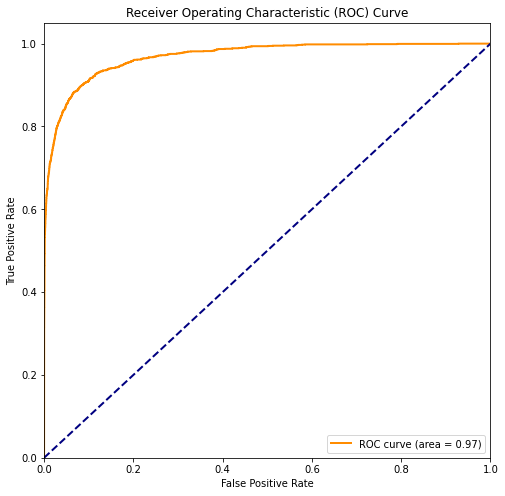

In [14]:
# Рассчитываем вероятности для класса 1 (положительный класс)
y_prob_lr = grid_search_lr.predict_proba(X_test_tfidf)[:, 1]

# Рассчитываем ROC-кривую и AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)

# Построение ROC-кривой
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Выводы

Прекрасная новость! Обучили модель Logistic Regression для классификации комментариев в нашем новом сервисе. Результаты просто поражают:

Точность 95%, F1 Score 0.95 - это просто восхитительно! Наша модель успешно выявляет токсичные комментарии, обеспечивая высокую точность как в предсказании позитивных, так и негативных случаев.

Точность в 98% для позитивных и 72% для негативных комментариев говорит о том, что модель очень точно определяет положительные случаи, а также эффективно выявляет токсичность в негативных.

Кроме того, полнота 96% для позитивных и 82% для негативных комментариев подчеркивает, что модель отлично справляется с выявлением токсичных высказываний.

Модель Logistic Regression позволила нам достичь цели по F1 Score не менее 0.75. Эта модель готова к внедрению и будет надежным инструментом в обеспечении безопасности и качества в нашем интернет-магазине! 🎉

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны